<a href="https://colab.research.google.com/github/Aparna-U-Nair/Simpsons-Character-Recognition/blob/master/SimpsonsCharRecog_LittleVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
from os.path import join, isfile
from os import listdir
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import sys
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from __future__ import print_function
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Conv2D, Flatten, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.layers.advanced_activations import ELU

In [4]:
num_classes = 20
rows,cols = 32,32
batch_size = 32

train_path = "/content/gdrive/My Drive/Colab Notebooks/simpsons/train/"
test_path = "/content/gdrive/My Drive/Colab Notebooks/simpsons/test"

#Using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range =30,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(rows,cols),
        batch_size=batch_size,
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(rows,cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 19558 images belonging to 20 classes.
Found 990 images belonging to 20 classes.


In [ ]:
#Create the VGG9 model
model = Sequential()

#1st Conv-Relu Layer
model.add(Conv2D(64,(3,3),input_shape = (rows,cols,3),padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization())

#2nd Conv-Relu Layer
model.add(Conv2D(64,(3,3),input_shape = (rows,cols,3),padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization())

#Maxpooling with Dropout Layer
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

#3rd Conv-Relu Layer
model.add(Conv2D(128,(3,3),padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization())

#4th Conv-Relu Layer
model.add(Conv2D(128,(3,3),padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization())

#Maxpooling with Dropout Layer
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

#5th Conv-Relu Layer
model.add(Conv2D(256,(3,3),padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization())

#6th Conv-Relu Layer
model.add(Conv2D(256,(3,3),padding = "same"))
model.add(Activation("relu"))
model.add(BatchNormalization())

#Maxpooling with Dropout Layer
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

#1st FC layer
model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#2nd FC layer
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Final output layer
model.add(Dense(num_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)       

In [ ]:
#Model Visualization
# %matplotlib inline
# from keras.utils.vis_utils import plot_model
# from matplotlib.image import mpimg
# plot_model(model,to_file = "/content/gdrive/My Drive/Colab Notebooks/simpsons/VGG9.png", show_shapes = True, show_layer_names = True)
# img = mpimg.imread("/content/gdrive/My Drive/Colab Notebooks/simpsons/VGG9.png")
# plt.figure(figsize=(100,70))
# plot = plt.imshow(img)

In [ ]:
# Train the VGG9 model

from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(filepath = "/content/gdrive/My Drive/Colab Notebooks/simpsons/model.{epoch:02d}-{val_loss:.2f}.h5",
                             monitor = "val_loss",
                             mode = "min",
                             save_best_only = True,
                             verbose = 1)
es = EarlyStopping(monitor = "val_loss",
                   min_delta = 0,
                   patience = 3,
                   verbose = 1,
                   restore_best_weights = True)
lr = ReduceLROnPlateau(monitor = "val_loss",
                       factor = 0.2,
                       min_delta = 0.00001,
                       patience = 3,
                       verbose = 1)

callbacks = [checkpoint, es, lr]

model.compile(loss = "categorical_crossentropy",
              optimizer = Adam(lr = 0.01),
              metrics = ["accuracy"])

#sample size from data generator out
train_samples = 19548
test_samples = 990
epochs = 20

hist = model.fit(train_generator,
                steps_per_epoch = train_samples // batch_size,
                epochs = epochs,
                callbacks = callbacks,
                validation_data = test_generator,
                validation_steps = test_samples//batch_size
                 )

Found 990 images belonging to 20 classes.
CLASS LABELS: {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lenny_leonard', 11: 'lisa_simpson', 12: 'marge_simpson', 13: 'mayor_quimby', 14: 'milhouse_van_houten', 15: 'moe_szyslak', 16: 'ned_flanders', 17: 'nelson_muntz', 18: 'principal_skinner', 19: 'sideshow_bob'}
CLASSES: ['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson', 'charles_montgomery_burns', 'chief_wiggum', 'comic_book_guy', 'edna_krabappel', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lisa_simpson', 'marge_simpson', 'mayor_quimby', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'principal_skinner', 'sideshow_bob']
CM
[[32  0  0  0  0  0  0 12  0  0  2  0  1  0  0  1  0  0  0  0]
 [ 0 49  0  0  0  0  0  0  0  0  1  0  0  0  0 

<Figure size 576x576 with 0 Axes>

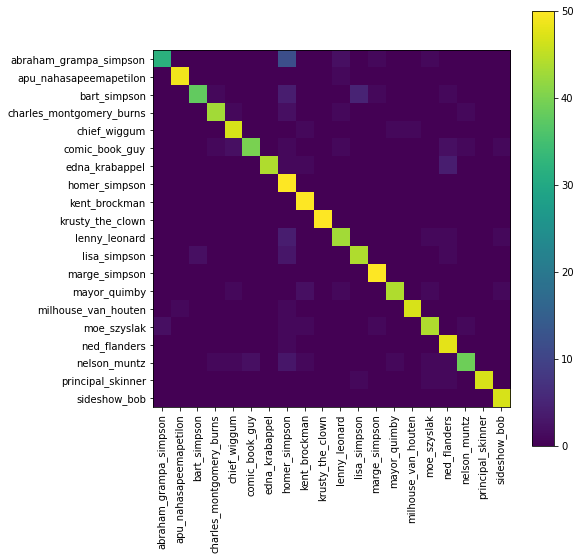

In [43]:
#Performance Analysis
from sklearn.metrics import classification_report, confusion_matrix

#Recreating the test datagen by keeping shuffle = False
val_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(rows,cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False)

class_labels = val_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}
classes= list(class_labels.values())
tick_marks = len(classes)

print(f"CLASS LABELS: {class_labels}")
print(f"CLASSES: {classes}")

train_samples = 19548
test_samples = 990

y_pred = my_model.predict(val_generator, test_samples//batch_size+1)
y_pred = np.argmax(y_pred,axis = 1)

cm = confusion_matrix(val_generator.classes, y_pred)
print("CM")
print(cm)
print("Class Report")
print(classification_report(val_generator.classes, y_pred, target_names = classes))
plt.figure(figsize=(8,8))
plt.imshow(cm,interpolation="nearest")
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks,classes, rotation =90 )
_ = plt.yticks(tick_marks, classes)


In [6]:
my_model = load_model("/content/gdrive/My Drive/Colab Notebooks/simpsons/vgg9.h5")

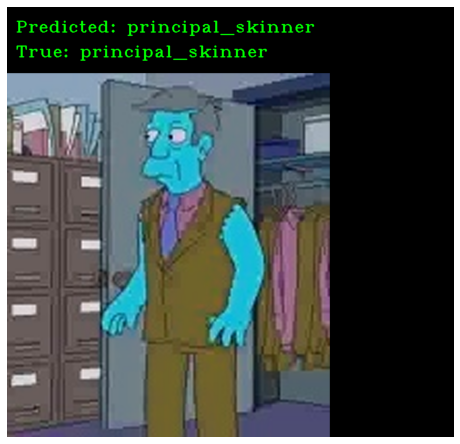

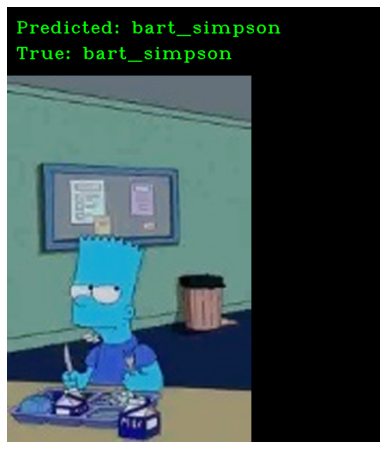

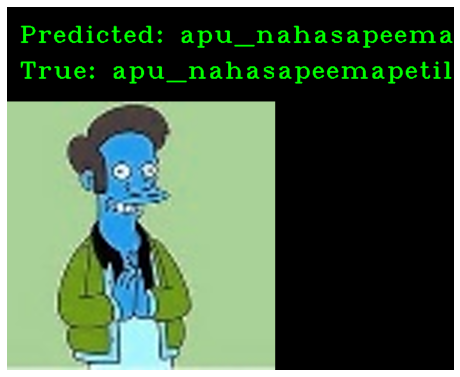

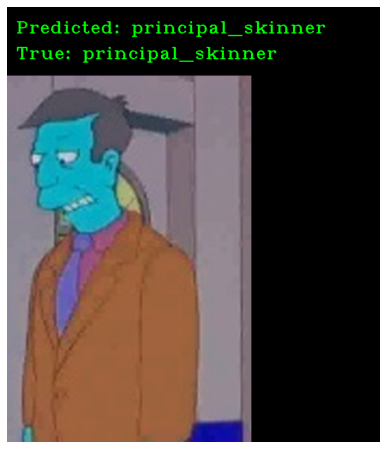

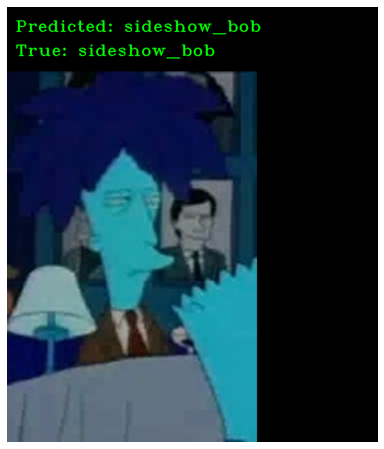

-1

In [44]:
#Testing some random images
from keras.preprocessing import image
def draw_test_img(name,pred,input_img,true_label):
  black = [0,0,0]
  final_img = cv2.copyMakeBorder(input_img,160,0,0,300, cv2.BORDER_CONSTANT, value =black)
  cv2.putText(final_img,"Predicted: "+pred,(20,60),cv2.FONT_HERSHEY_COMPLEX_SMALL,2,(0,255,0),2)
  cv2.putText(final_img,"True: "+true_label,(20,120),cv2.FONT_HERSHEY_COMPLEX_SMALL,2,(0,255,0),2)
  # cv2.imshow(name,final_img)
  plt.figure(figsize=(8,8))
  plt.imshow(final_img)
  plt.axis("off")
  plt.show()
    
def get_rand_img(path, wid, hei):
  #Load a random image from the test folder
  folders = list(filter(lambda x: os.path.isdir(os.path.join(path,x)),os.listdir(path)))
  rand_dir = np.random.randint(len(folders))
  path_class = folders[rand_dir]
  file_path = path+path_class
  file_names = [f for f in listdir(file_path) if isfile(join(file_path,f))]
  rand_idx = np.random.randint(len(file_names))
  img_name = file_names[rand_idx]
  final_path = file_path + "/" + img_name
  return image.load_img(final_path, target_size = (width, height)), final_path, path_class


width, height = 32,32
files= []
preds = []
true_lab = []

for i in range(5):
  path = "/content/gdrive/My Drive/Colab Notebooks/simpsons/test/"
  img, fin_path, true_label = get_rand_img(path, width, height)
  files.append(fin_path)
  true_lab.append(true_label)
  x = image.img_to_array(img)
  x = x* 1./255
  x = np.expand_dims(x, axis = 0)
  images= np.vstack([x])
  classes = my_model.predict_classes(images, batch_size=10)
  preds.append(classes)

for i in range(len(files)):
  image = cv2.imread(files[i])
  image = cv2.resize(image, None, fx = 5, fy = 5, interpolation = cv2.INTER_CUBIC)
  draw_test_img("Prediction",class_labels[preds[i][0]], image, true_lab[i])
    
cv2.waitKey(0)
cv2.destroyAllWindows()
